# EV Charging: Probabilistic Binary Classification

**Goal:** Predict the probability that an EV charging session will be "Short" (< 24 hours) vs. "Long" (>= 24 hours).
**Approach:** Neural Network Classifier with Class Weights and Regularization.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

/Users/cyrils/Developer/Python/NeuralNetworks/.venv/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


## 1. Load Data

In [2]:
df = pd.read_csv('data/ev_sessions_clean.csv')
print(f"Data Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

# Verify Target
target = 'is_short_session'
print("\nClass Distribution (1=Short, 0=Long):")
print(df[target].value_counts(normalize=True))

Data Shape: (6745, 29)
Columns: ['session_ID', 'Garage_ID', 'User_ID', 'User_type', 'Shared_ID', 'Start_plugin', 'Start_plugin_hour', 'End_plugout', 'End_plugout_hour', 'El_kWh', 'Duration_hours', 'month_plugin', 'weekdays_plugin', 'Plugin_category', 'Duration_category', 'Start_plugin_dt', 'date', 'temp', 'precip', 'clouds', 'solar_rad', 'wind_spd', 'End_plugout_dt', 'Duration_check', 'hour', 'hour_sin', 'hour_cos', 'weekday', 'is_short_session']

Class Distribution (1=Short, 0=Long):
is_short_session
1    0.932394
0    0.067606
Name: proportion, dtype: float64


## 2. Preprocessing
Prepare features for the neural network.

In [3]:
# Select Features
numerical_cols = ['hour_sin', 'hour_cos', 'temp', 'precip', 'wind_spd']
categorical_cols = ['weekday', 'Garage_ID']

X = df[numerical_cols + categorical_cols]
y = df[target]

# Split (Shuffle=False for time series, but here we do random split for basic valid)
# Chronological split is better, but let's stick to standard 80/20 first
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ]
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"Processed Train Shape: {X_train_processed.shape}")
print(f"Processed Test Shape: {X_test_processed.shape}")

Processed Train Shape: (5396, 36)
Processed Test Shape: (1349, 36)


## 3. Class Weights
Address class imbalance (Long sessions are minority).

In [4]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

print("Class Weights:", class_weights)

Class Weights: {np.int64(0): np.float64(7.391780821917808), np.int64(1): np.float64(0.5362750944146293)}


## 4. Model Architecture (Regularized MLP)

In [5]:
def build_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(16, activation='relu'),
        
        Dense(1, activation='sigmoid')  # Output probability
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

model = build_model(X_train_processed.shape[1])
model.summary()

/Users/cyrils/Developer/Python/NeuralNetworks/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         2,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,377 (21.00 KB)

 Trainable params: 5,185 (20.25 KB)

 Non-trainable params: 192 (768.00 B)

## 5. Training

In [6]:
history = model.fit(
    X_train_processed, y_train,
    validation_data=(X_test_processed, y_test),
    epochs=50,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[
        EarlyStopping(patience=10, restore_best_weights=True, monitor='val_auc', mode='max'),
        ReduceLROnPlateau(patience=5, factor=0.5, monitor='val_auc', mode='max')
    ],
    verbose=1
)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6434 - auc: 0.5651 - loss: 0.7334 - val_accuracy: 0.6990 - val_auc: 0.6346 - val_loss: 0.6473 - learning_rate: 0.0010
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step - accuracy: 0.6164 - auc: 0.6308 - loss: 0.6822 - val_accuracy: 0.6605 - val_auc: 0.6717 - val_loss: 0.6445 - learning_rate: 0.0010
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step - accuracy: 0.6427 - auc: 0.6835 - loss: 0.6436 - val_accuracy: 0.6368 - val_auc: 0.6853 - val_loss: 0.6684 - learning_rate: 0.0010
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - accuracy: 0.6610 - auc: 0.7104 - loss: 0.6249 - val_accuracy: 0.6731 - val_auc: 0.7092 - val_loss: 0.6430 - learning_rate: 0.0010
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - accuracy: 0.6835 - auc: 0.7265 - loss: 0.6115 - val_accuracy: 0.6783 - val_auc: 0.7240 - val_loss: 0.6263 - learning_rate: 0.0010
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step - accuracy: 0.6927

## 6. Evaluation

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
ROC-AUC Score: 0.7478

Classification Report:
              precision    recall  f1-score   support

Long (>=24h)       0.14      0.68      0.23        91
Short (<24h)       0.97      0.69      0.80      1258

    accuracy                           0.68      1349
   macro avg       0.55      0.68      0.51      1349
weighted avg       0.91      0.68      0.76      1349



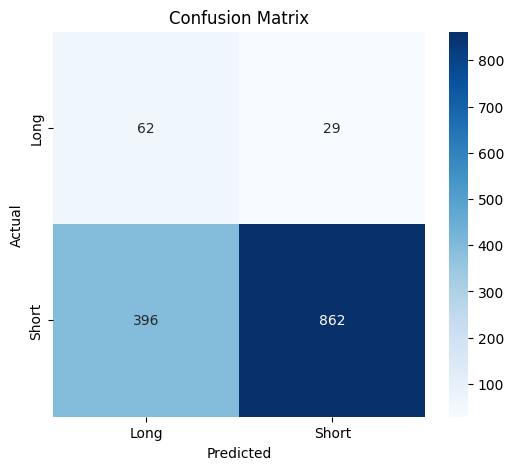

In [7]:
# Predictions
y_pred_proba = model.predict(X_test_processed).ravel()
y_pred_class = (y_pred_proba > 0.5).astype(int)

# Metrics
auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_class, target_names=['Long (>=24h)', 'Short (<24h)']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Long', 'Short'], yticklabels=['Long', 'Short'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [8]:
# Threshold tuning for Long (>=24h) class using F1
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

# Short-class probabilities from the trained model
proba_short = model.predict(X_test_processed).ravel()
proba_long = 1.0 - proba_short

# Long class labels: 1 if long, 0 if short
y_long_true = (y_test == 0).astype(int)

best = {"threshold": 0.5, "precision": 0.0, "recall": 0.0, "f1": -1.0}
for t in np.linspace(0.1, 0.9, 81):
    y_long_pred = (proba_long >= t).astype(int)
    p, r, f1, _ = precision_recall_fscore_support(y_long_true, y_long_pred, average='binary', zero_division=0)
    if f1 > best["f1"]:
        best = {"threshold": float(t), "precision": float(p), "recall": float(r), "f1": float(f1)}

print(f"Best threshold for LONG class (by F1): {best['threshold']:.3f}")
print(f"Precision (Long): {best['precision']:.3f} | Recall (Long): {best['recall']:.3f} | F1 (Long): {best['f1']:.3f}")

# Confusion matrix at best threshold
y_long_pred_best = (proba_long >= best["threshold"]).astype(int)
cm = confusion_matrix(y_long_true, y_long_pred_best)
print("\nConfusion Matrix (Long=1, Short=0):")
print(cm)


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
Best threshold for LONG class (by F1): 0.670
Precision (Long): 0.183 | Recall (Long): 0.440 | F1 (Long): 0.258

Confusion Matrix (Long=1, Short=0):
[[1079  179]
 [  51   40]]
